In [1]:
import numpy as np
from copy import deepcopy as Dcp
from math import sqrt, floor, ceil
import os
import time

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import optimizers as optmz
import random
import pandas as pd
import matplotlib.pyplot as plt


#np.random.seed(392)

Using TensorFlow backend.


## ---------------------------------------------------------------------------------------------------------------
## MINST DATA AND PERDICTION
## ---------------------------------------------------------------------------------------------------------------

In [2]:
from keras.datasets.mnist import load_data

(train_digits, train_labels), (test_digits, test_labels) = load_data()

In [3]:
from keras.utils import to_categorical
height = train_digits.shape[1]
width = train_digits.shape[2]
channels = 1

train_digits = np.reshape(train_digits, (train_digits.shape[0], height, width, channels))
test_digits = np.reshape(test_digits, (test_digits.shape[0], height, width, channels))

#normalize values to   0 <= value <= 255
train_digits = (train_digits.astype('float32')*(10000 - -10000)/ 255.0) + (-10000)
test_digits = (test_digits.astype('float32')*(10000 - -10000)/ 255.0) + (-10000)

total_categories = 10
op_label_train = to_categorical(train_labels, num_classes=10)
op_label_test = to_categorical(test_labels, num_classes=10)

In [4]:
for _ in range(10):
    indexes = np.random.permutation(len(train_digits))
    
#shuffled the training dataset
train_digits = train_digits[indexes]
op_label_train = op_label_train[indexes]


validity_fract = 0.15
fract = int(len(train_digits) * validity_fract)

val_digits = train_digits[:fract,:]
op_label_val = op_label_train[:fract,:]

train_digits = train_digits[fract:,:]
op_label_train = op_label_train[fract:,:]

In [5]:
model = Sequential()

model.add( Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',
                 input_shape=(height,width,channels) )
         )
model.add( MaxPooling2D(pool_size=(2,2)) )

model.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(2,2)) )

model.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(2,2)) )

model.add(Flatten())

model.add( Dense(128, activation='relu') )
model.add( Dense(10,activation='softmax') )

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.


In [6]:
NUM_EPOCH = 11
BATCH_SIZE = 204

#FOR BACKPROP
model1 = Sequential()

model1.add( Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',
                 input_shape=(height,width,channels) )
         )
model1.add( MaxPooling2D(pool_size=(2,2)) )

model1.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu') )
model1.add( MaxPooling2D(pool_size=(2,2)) )

model1.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu') )
model1.add( MaxPooling2D(pool_size=(2,2)) )

model1.add(Flatten())

model1.add( Dense(128, activation='relu') )
model1.add( Dense(10,activation='softmax') )

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#results = model1.fit(train_digits, op_label_train, epochs=NUM_EPOCH, batch_size=BATCH_SIZE,
#                   validation_data=(val_digits,op_label_val))

In [7]:
shape_dic = {}
for i, each_layer in enumerate(model.layers):
    wts = each_layer.get_weights()
    if not wts:
        wts = [[],[]]
    shape_dic[str(i)] = {'wt':np.shape(wts[0]), 'bi':np.shape(wts[1]), 'name':each_layer.name}

In [8]:
def flatten_model_params(model_obj, meta_info=shape_dic):
    '''
    meta_info : dictionary that contains info abt each layer
            wts and biases dimentions
    RETURNS: a python list of "flattened" wts. and biases
    '''
    i = 0
    all_li = []
    for i, ly in enumerate(model_obj.layers):
        wts = ly.get_weights()
        if not wts:
            continue
        wt = wts[0]
        bia = wts[1]
        _wt = wt.reshape(
                            (1, np.prod(meta_info[str(i)]['wt']))
                        ).tolist()[0]
        _bi = bia.reshape(
                            (1, np.prod(meta_info[str(i)]['bi']))
                        ).tolist()[0]
        all_li += _wt
        all_li += _bi
    return all_li

def unflatten_model_params(wt_bi_list, meta_info=shape_dic):
    '''
    Takes a long list of weighs and biases obtained from
    "flatten_model_params" and then retuns a dictionary with
    weights and biases as np.arrays per layer
    '''
    i=0
    all_dic = {}
    for lyr, dims in meta_info.items():
        wt_shape = dims['wt']
        bias_shape = dims['bi']
        _wt = wt_bi_list[0: np.prod(wt_shape)]
        wt_bi_list = wt_bi_list[np.prod(wt_shape) : ]
        _bt = wt_bi_list[0: np.prod(bias_shape) ]
        wt_bi_list = wt_bi_list[np.prod(bias_shape) : ]
        all_dic[lyr] = {
                        'wt': np.array(_wt).reshape(wt_shape) , 
                        'bi': np.array(_bt).reshape(bias_shape),
                        'name': dims['name']
                        }
    return all_dic

In [9]:
def model_eval(model_obj, X, Y, ret_acc=False,
              batches=BATCH_SIZE, verbose=False):
    '''
    Assumes that wts and biases are set
    in "model_obj". X is observations
    Y is label
    
    BatchSize is set to "51"
    
    Returns (loss)*-1 if "ret_acc"
    is not set else
    accuracy*100 is also returned
    '''
    loss, acc = model_obj.evaluate(X, Y, batch_size=batches,
                                   verbose=verbose)
    if ret_acc:
        return (acc*100, (loss)*-1)
    return (loss)*-1

In [10]:
def fitness_func(f, arr, feats=test_digits,# train_digits,
                 oplabes=op_label_test, #train,
                 model_obj=model,
                 reshape_func=unflatten_model_params):
    '''
    f: a function that needs to be ecaluated
    arr: the input to f (hopefully an array of position
          in search space)
    
    returns a num which is the fitness values at "arr"
    '''
    if not f:
        raise Exception('Function not set')
        
    for ly, ars in reshape_func(arr).items():
            if ars['wt'].size == 0 and ars['bi'].size == 0:
                continue
            model_obj.layers[int(ly)].set_weights(
                                                [ ars['wt'], ars['bi'] ]
                                             )
    return f(model_obj, feats, oplabes)

## ---------------------------------------------------------------------------------------------------------------
## END of MINST DATA AND PERDICTION
## ---------------------------------------------------------------------------------------------------------------

In [11]:
# ALGO PARAMETERS

#Population
population = []
population_size = 10 #30 #No of particles we want to exist

#Max allowable strength of a baboon
st_max = 100

#Min strength of a baboon
st_min = 5

#Max Stride length
stride_max = 200

#Min stride lenth
stride_min = 3

#Fencing archive
m = 15 #Number of records of fences we would keep
Fence = [] #List of elems : objs of class "fence_elem"

#Global best position found as yet
gbest = None #Position of the best solution so far
gbest_value = -99999999999 #fitness value of the current gbest
gbest_placeholder_radius = None

#Importance to pbest and gbest values
pb_wt = 2
gb_wt = 6


#Dicts to track distance to other fences and baboons

#it will consists of keys-(ID1,ID2) with value as
#distance. this relation is symmetric as in
#(ID1,ID2) == (ID2,ID1)
bab2bab = {}

#This will be of form: key - (ID, Fence index)
#value is the distance of baboon to fence
bab2fence = {}

#Number of iterations of the entire cycle that we would
#run the algo for before stopping
num_loops = 500 #3000

#Probablity of how sparse the 'mask' vector is when 
#choosing a new point inside the Fence element. It 
#fraction of pts we want to move in. Should be b/w
#1 and 0. 0 means we remain at the same place
p_fract = 0.2

#Fraction of population that (stochastically)
#must move per iteration. Set to 0 if none should
#move, set to 1 if all must move
fract_moving_pop = 1 #0.8

#Fraction of elite Fence elements that will 
#exploit the space within them. Set 0 so 
#that none of the fence elements move, 1
#for all of them to move
fence_elitism_fract = 0.4

#Probablity of an non elite fence element to
#move(exploit) its arear within itself
fence_non_elite_prob = 0.05

In [12]:
def dist_cal(pos1, pos2):
    '''
    pos1 and pos2 are positions
    '''
    if len(pos1) != len(pos2):
        raise Exception('Length of pos1 and pos2 not equal %s N %s' \
                       %(pos1,pos2))
        
    return sqrt( ((np.array(pos1) - np.array(pos2))**2).sum() )

In [13]:
def scale_vector(vector, factor=None):
    '''
    Scales a numpy vector by factor
    '''
    if factor:
        if not np.all(vector==0):
            #cannot scale 0 vector
            vector = (vector / np.linalg.norm(vector) ) * factor
    return vector

In [14]:
def make_vector(final, begin, scale=None, ret_list=False):
    '''
    Given 2 points final and begin in some n Dimention
    Return the vector of these 2 points
    
    ret_list: Flag to indicate of vector returned should be
                in a list format
                
    We assume vectors in numpy nD array form
    '''
    if len(final) != len(begin):
        #Dimentions dont match
        raise Exception('Dimentions of final pt. and begin pt. do not match Final:%s Begin:%s'
                       %(final,begin))
    vec = np.array(final) - np.array(begin)
    vec = scale_vector(vec, factor=scale)
    if ret_list:
        return vec.tolist()
    return vec

In [15]:
def resultant_vector(list_of_vec, ret_list=False):
    '''
    Returns the resultant of the vectors in "list_of_vec"
    (default form numpy array)
    ret_list: If set returns resultant as a list not numpy arr
    '''
    if not list_of_vec:
        raise Exception('Empty list of vectors to be added')
    vecs = list(map(lambda x: np.array(x) , list_of_vec))
    result = vecs[0]
    for i in range(1,len(vecs)):
        result += vecs[i]
    if ret_list:
        return result.tolist()
    return result

In [16]:
def find_space_violations(own_ID, own_space, janta=population, fences=Fence):
                       #to_baboon=bab2bab, to_fence=bab2fence):
    '''
    Depending on the distance of the particle to other entites
    we check if the personal spaces overlap or not
    
    Returns a list of positions with overlap, the overlap might
    be with a fence or a personal space
    '''
    global bab2bab
    global bab2fence
    
    viol = []
    for single in janta:
        if single.ID == own_ID:
            continue
        key = (own_ID, single.ID) if (own_ID, single.ID) in bab2bab \
                else (single.ID, own_ID)
        dist = bab2bab[key]
        if dist < own_space + single.personal_space[1]: #The radius of hyper-sphere
            viol.append(single.curr_position)
            #print('%s is in violation of space of ID:%s' %(own_ID,single.ID)) #DEBUG
            
    for index, picket in enumerate(fences):
        dist = bab2fence[(own_ID, index)]
        if dist < own_space + picket.radius:
            #print('%s is in violation of space of FENCE:%s' %(own_ID,index)) #DEBUG
            viol.append(picket.position)
            
    return viol

In [17]:
def dist_to_everything(own_pos, own_ID, janta=population, fences=Fence,
                       #to_baboon=bab2bab, to_fence=bab2fence,
                       dist_func=dist_cal):
    '''
    This function is to be called by a particle at
    position "own_pos" with ID:own_ID. "janta" and
    "fences" are popluation list and list of fence
    archive
    
    It populates the "bab2bab" dict and "to_fenc
    e" in the format specified when these dicts ar
    e first created
    '''
    global bab2bab
    global bab2fence
    
    for single in janta:
        if single.ID == own_ID:
            continue
        #dist to other baboons
        key = (own_ID, single.ID) if (own_ID, single.ID) in bab2bab \
                else ((single.ID, own_ID) if (single.ID, own_ID) in bab2bab \
                                          else (own_ID, single.ID))
        bab2bab[key] = dist_func(own_pos, single.curr_position)
        
    for index, picket in enumerate(fences):
        bab2fence[(own_ID,index)] = dist_func(own_pos, picket.position)

In [18]:
class fence_elem:
    def __init__(self, fence_center, fence_radius, fitness_value,
                fit_sub=fitness_func, f=model_eval):
        
        global gbest
        global gbest_value
        
        hi = 1
        lo = hi*-1
        self.position = fence_center #The Center of the Fence
        self.radius = fence_radius
        self.fit_val = fitness_value
        a_pos = [i + (np.random.uniform(lo,hi)) for i in self.position]
        a_counter = 0
        while dist_cal(a_pos, self.position) > self.radius:
            if a_counter < 25:
                print('Dist of random Pt outside Fence element') #DEBUG
                print('DIst: %s -- Radius:%s' %(dist_cal(a_pos, self.position), self.radius)) #DEBUG
                hi /= 2
                lo /= 2
                a_pos = [i + (np.random.uniform(lo,hi)) for i in self.position]
            else:
                print('Take same position as FenceCenter') #DEBUG
                a_pos = Dcp(self.position) #Just take the same position as the fence center
                self.radius *= 1.1 #Increase fence radius so that this can move on
                a_counter = 0
                hi = 1
                lo = hi*-1
                continue
            a_counter += 1
                
        #print('DIst: %s -- Radius:%s' %(dist_cal(a_pos, self.position), self.radius)) #DEBUG
        it_fit = fit_sub(f,a_pos)
        if gbest_value < it_fit:
            gbest_value = it_fit
            gbest = Dcp(a_pos)
        self.settler = self.Settler(a_pos,Dcp(self.radius),
                                    Dcp(self.fit_val), Dcp(self.position))
        
    class Settler:
        def __init__(self, pos, limit, fitness_score,
                    fence_center):
            self.edge_dist = limit
            self.position = pos
            self.fitness_score = fitness_score
            self.fence_center = fence_center
            self.avg_score = fitness_score
            self.N = 1
            
        def recalculate_avg_score(self):
            '''
            I assume that the self.fitness_score
            is already calculated and stored
            Calling this function should be after
            the new fitness score is calculated
            '''
            
            self.avg_score = (self.avg_score*self.N + self.fitness_score)/(self.N + 1)
            self.N += 1
        
        def move_settler(self, fit_fun=fitness_func,f=model_eval,
                        grad_step_size=0.25):
            
            global gbest
            global gbest_value
            
            tick_1 = time.time()  #FOR TIME
            
            interim_fitness = -9999999
            while abs(interim_fitness - self.fitness_score) > 0.1:
                mask = np.random.choice([0, 0.25, -0.25], p=[1 - p_fract, p_fract/2, p_fract/2],
                                       size=np.size(self.position))
                new_pos = list(np.array(self.position) + mask)
                interim_fitness = fit_fun(f, new_pos)
                #print('InLoop taking %s -- %s' %(interim_fitness, self.fitness_score))  #DELETE THIS
            
            #for dim in range(len(self.position)):
            #    temp_mask[dim] = grad_step_size
            #    new_pos = list(np.array(self.position) + temp_mask)
            #    if fit_fun(f, new_pos) > self.fitness_score:
            #        mask[dim] += grad_step_size
                
            #    temp_mask[dim] = grad_step_size * -1
            #    new_pos = list(np.array(self.position) + temp_mask)
            #    if fit_fun(f, new_pos) > self.fitness_score:
            #        mask[dim] += (grad_step_size * -1)
                
            #    temp_mask = np.zeros_like(self.position)
                
            #    tick_2 = time.time()  #FOR TIME
                
            tick_3 = time.time()  #FOR TIME
            
            #new_pos = np.array(self.position) + mask
            
            tick_4 = time.time()  #FOR TIME
            
            heading = make_vector(new_pos, self.position,
                                  scale=np.random.uniform(0.1, 1) #Adjust this range to adjust stride
                                 )
            
            tick_5 = time.time()  #FOR TIME
            
            interim_pos = (np.array(self.position) + heading).tolist()
            if dist_cal(interim_pos, self.fence_center) > self.edge_dist:
                
                tick_5_5 = time.time()  #FOR TIME
                
                self.reset_settler()
                
                tick_5_6 = time.time()  #FOR TIME
                #print('ResetSettler:%s' %(tick_5_6 - tick_5_5)) #DELETE THIS
                return
                
            tick_6 = time.time()  #FOR TIME
            
            interim_fitness = fit_fun(f, interim_pos)
            
            tick_7 = time.time()  #FOR TIME
            
            if interim_fitness > self.fitness_score:
                self.fitness_score = interim_fitness
                self.recalculate_avg_score()
                self.position = Dcp(interim_pos)
                if interim_fitness > gbest_value:
                    gbest_value = interim_fitness
                    gbest = Dcp(interim_pos)
                    
                #print('TimeBumpUPfitness :%s' %(time.time() - tick_7))  #DELET THIS
            else:
                self.position = Dcp(new_pos)
                self.fitness_score = fit_fun(f, new_pos)
                self.recalculate_avg_score()
                if self.fitness_score > gbest_value:
                    gbest_value = self.fitness_score
                    gbest = Dcp(self.position)
                
                #print('TimeSmplUpdate :%s' %(time.time() - tick_7))  #DELET THIS
                
            #DELETE THE FOLLOWING, ONLY FOT DEBUG
            #print('TimePickGradient:%s -- MakeVector: %s -- DistNreset: %s -- CalFItness: %s' \
            #     %(tick_3 - tick_1, tick_5 - tick_4, tick_6 - tick_5, tick_7 - tick_6))
                
        def reset_settler(self, fit_fun=fitness_func,f=model_eval):
            
            global gbest
            global gbest_value
            
            _hi = 1
            _lo = _hi * -1
            curr = [(i + np.random.uniform(_lo,_hi))  for i in self.fence_center]
            a_count = 0
            while dist_cal(self.fence_center, curr) > self.edge_dist:
                if a_count < 25:
                    print('reset_settler has resettled outside fence') #DEBUG
                    _hi /= 2
                    _lo /= 2
                    curr = [(i + np.random.uniform(_lo,_hi))  for i in self.fence_center]
                else:
                    curr = Dcp(self.fence_center)
                a_count += 1
                
            self.position = Dcp(curr)
            self.fitness_score = fit_fun(f,self.position)
            self.recalculate_avg_score()
            if self.fitness_score > gbest_value:
                    gbest_value = self.fitness_score
                    gbest = Dcp(self.position)
        
def update_fences(fence=Fence, capacity=m):
    '''
    This function will be called after all particles have 
    moved and the gbest is to be inducted into the Fences
    '''
    global gbest
    global gbest_placeholder_radius
    global gbest_value
    
    if not gbest or not gbest_placeholder_radius or not gbest_value:
        return
    
    g_B = fence_elem(gbest, gbest_placeholder_radius, gbest_value)
    
    if len(fence) < capacity:
        status = any( [
                        bool(dist_cal(gbest, i.position) < 1) for i in fence
                        ] )
        if not status:
            fence.append(g_B)
    else:
        near = 99999999
        idx = None
        for index, elem in enumerate(fence):
            dst = dist_cal(gbest + [gbest_placeholder_radius] , 
                            elem.position + [elem.radius])
            if dst < near:
                near = dst
                idx = index
        if not idx:
            if fence[idx].fit_val < gbest_value:
                fence[idx] = g_B
        #else no changes

In [19]:
class baboon:
    def __init__(self, ID, curr_position, fitness_function=fitness_func,
                pt2vec=make_vector, vec_scale=scale_vector,
                actual_func_fit=model_eval,fit_val_negative=True):
        '''
        Note: The correct order is to set "strength" before setting
                "personal_space" through the class methods
        '''
        #The following are taken as global in this class, if a custom
        #object is to be used, create own defination of the object
        # - st_min and st_max
        # - stride_max and stride_min
        # - dist_to_everything and find_space_violations
        
        self.ID = ID
        self.curr_position = curr_position
        self.fitness_function = fitness_function
        self.actual_func_fit = actual_func_fit
        self.fitness_value = fitness_function(actual_func_fit, curr_position)
        self.fitness_value_prev = Dcp(self.fitness_value) #For initialization use same
        self.strength = np.random.uniform(st_min, st_max)
        self.stride = np.random.uniform(stride_min, stride_max)
        self.fitness_val_negative = fit_val_negative
        #Flag to indicate if fitness values are negative. If so
        #then 0.0 is the max value
        
        self.personal_space = ( self.curr_position ,
                               np.random.uniform(st_min, st_max) )
        
        self.pbest = Dcp(curr_position)
        self.pbest_fitness = Dcp(self.fitness_value)
        
        #function to make a vector and scale vector
        self.vec_scale = vec_scale
        self.pt2vec = pt2vec
        
        #Randomly Initialize velocity vector
        #it is a numpy array unlike curr_position
        #which is going to be a list
        self.velocity = self.pt2vec([np.random.normal(abs(i), abs(i)*3) for i in self.curr_position],
                                    self.curr_position,
                                   scale=self.stride)
        
        #All of this is only for initializatons 
        
    def set_stridelength(self, fence=Fence):
        #StrideLength(t) : StrideLength(t-1) x Fencing x PersonalSpace(t-1) x σ(0,1) -> R
        if self.fitness_val_negative:
            change = (abs(self.fitness_value_prev) - abs(self.fitness_value))/abs(self.fitness_value_prev)
        else:
            change = (abs(self.fitness_value_prev) - abs(self.fitness_value))/abs(self.fitness_value_prev)

        self.stride = self.stride*(1 + change)
        if self.stride > stride_max:
            self.stride = stride_max
        if self.stride < stride_min:
            self.stride = stride_min
        
    def set_personalspace(self):
        #TODO:
        #PersonalSpace(t) : Strength(t) x Position(t) -> ( Position(t) , R )
        
        pos_t , R_t_1 = self.personal_space
        change = (self.strength - self.strength_t_1)/self.strength_t_1
        R_t_1 *= 1+change        
        self.personal_space = (pos_t , R_t_1)
        
    def set_strength(self):
        #Strength(t) : Strength(t – 1) x Change in fitness -> R
        if self.fitness_val_negative:
            change = (abs(self.fitness_value_prev) - abs(self.fitness_value))/abs(self.fitness_value_prev)
        else:
            change = (abs(self.fitness_value_prev) - abs(self.fitness_value))/abs(self.fitness_value_prev)
            
        self.strength_t_1 = Dcp(self.strength)
        
        self.strength *= (1 + change)
        
        if self.strength > st_max:
            self.strength = st_max
        
        if self.strength < st_min:
            self.strength = st_min
    
    def move(self, p_weight=pb_wt, g_weight=gb_wt,
             vec_adder=resultant_vector, fence=Fence, fence_capacity=m):
            #, g_position=gbest,g_value=gbest_value, g_placeholder=gbest_placeholder_radius
        '''
        '''
        #TODO: 
        #    - get resutant vec and scale it
        #    - check if position violates any personal space
        #    - if yes move to "other" location(s) till no violation of spaces
        #    - update curr position
        #    - update fitness strength and personal spaces
        #    - update gbest with better sol if any
        
        global gbest_value
        global gbest_placeholder_radius
        global gbest
        global dist_to_everything
        global find_space_violations
        global bab2bab
        global bab2fence
        
        p_vec = self.pt2vec(self.pbest, self.curr_position, scale=p_weight)
        g_vec = self.pt2vec(gbest, self.curr_position, scale=g_weight)
        self.velocity = self.vec_scale( vec_adder([p_vec, g_vec, self.velocity]),
                            factor=self.stride+(0 if np.random.uniform(0,1) > 0.05 else 100))
        
        #cal the position, if there is a violation this will not be used. Otherwise
        #this will be the final position
        interim_position = (np.array(self.curr_position) + self.velocity).tolist()
        dist_to_everything(interim_position, self.ID)
        all_violations = find_space_violations(self.ID, self.personal_space[1])
        while all_violations:
            #print('%s ID had violation' %self.ID)
            #Centroid of all points in violation
            final_pt = np.array(all_violations).sum(axis=0).tolist()
            final_vec = self.pt2vec(final_pt, interim_position,
                                    scale=(-1)*(self.stride+(0 if np.random.uniform(0,1) > 0.05 else 100)))
            interim_position = (final_vec + np.array(interim_position)).tolist()
            dist_to_everything(interim_position, self.ID)
            all_violations = find_space_violations(self.ID, self.personal_space[1])
        
        #print('%s ID moved %s' %(self.ID, dist_cal(self.curr_position, interim_position))) #DELETE THIS LATER
        self.curr_position = Dcp(interim_position)
        
        #update all other params like pbest n stuff
        self.fitness_value_prev = Dcp(self.fitness_value)
        self.fitness_value = self.fitness_function(self.actual_func_fit,
                                                   self.curr_position)
        self.set_stridelength()
        self.set_strength()
        self.set_personalspace()
        
        if self.fitness_value > gbest_value:
            gbest_value = Dcp(self.fitness_value)
            gbest = Dcp(self.curr_position)
            gbest_placeholder_radius = Dcp(self.personal_space[1])
            
        if self.pbest_fitness < self.fitness_value:
            self.pbest_fitness = Dcp(self.fitness_value)
            self.pbest = Dcp(self.curr_position)
            gbest_placeholder_radius = Dcp(self.personal_space[1])
            

In [20]:
def get_avg_fitness(pop_list):
    '''
    Given a list of baboon() objs
    returns the average fitness
    '''
    return np.average([i.fitness_value for i in pop_list])

In [21]:
def get_avg_dist():
    '''
    Assumes dict "bab2bab" is completely
    populated and data is upto date
    
    Onlu calculates avg dist b/w each 
    baboons
    '''
    global bab2bab
    
    if not bab2bab:
        raise Exception('bab2bab dict is empty')
    
    return np.average([dis for key,dis in bab2bab.items()])
    

In [22]:
#INITIALIZE POPULATION
for indx, ii in enumerate(np.random.uniform(-10, 10, size=(population_size, len(flatten_model_params(model))))):
    population.append( baboon('bab_'+str(indx), ii.tolist()) )
    
mx = -999999999999
for each in population:
    if each.fitness_value > mx:
        mx = each.fitness_value
        gbest_placeholder_radius = each.personal_space[1]
        gbest = Dcp(each.curr_position)
gbest_value = mx

In [ ]:
#rough
gbest_X = []
avg_fit_X = []
gbest_value
for i in range(num_loops):
    for j in range(population_size):
        population[j].move()
    gbest_X.append(gbest_value)
    avg_fit_X.append(get_avg_fitness(population))

In [ ]:
#rough
gbest_X

In [ ]:
#rough
stop here
model1.fit(test_digits, op_label_test, batch_size=BATCH_SIZE, epochs=11)
res = model1.evaluate(val_digits, op_label_val, batch_size=BATCH_SIZE)
print(res)

In [ ]:
#The running part of the algo

#The following lists are for plotting
gbest_X = []
avg_fit_X = []
avg_dist = []
test_data_acc = []
evals = 0


X = test_digits
Y = op_label_test


print('Running The Main algo...')
bigbang = time.time()
for loopz in range(num_loops):
    start = time.time()
    for each_bab in population:
        if np.random.uniform(0,1) > fract_moving_pop:
            continue
        #start_bab_loop = time.time() #FOR TIME
        each_bab.move()
        #bab_mv_time = time.time() - start_bab_loop #FOR TIME
        #start_up_fence = time.time() #FOR TIME
        update_fences()
        #up_fence_time = time.time() - start_up_fence #FOR TIME
        
        gbest_X.append(gbest_value)
        avg_fit_X.append(get_avg_fitness(population))
        evals += 1
        #bab_loop = time.time() - start_bab_loop #FOR TIME
        #print('\n') #DELETE THIS
        #print('BaboonMove:%s -- FenceUpd:%s -- TotalBaboon:%s' \
        #     %(bab_mv_time, up_fence_time, bab_loop))
        
    end_bab_loop_all = time.time() #FOR TIME
        
    if m == len(Fence):
        Fence.sort(key=lambda x:x.settler.avg_score, reverse=True)
        limt = int(fence_elitism_fract*len(Fence))
        for i in range(len(Fence)):
            if i <= limt:
                Fence[i].settler.move_settler()
                Fence[i].settler.move_settler()
            elif np.random.uniform(0,1) <= fence_non_elite_prob:
                Fence[i].settler.move_settler()
                Fence[i].settler.move_settler()
    else:
        for each_fence in Fence:
            #For each baboon iteration move the
            #settlers in the fence twice
            #start_mv_settler = time.time() #FOR TIME
            each_fence.settler.move_settler()
            #mv_settler1 = time.time() - start_mv_settler #FOR TIME
            each_fence.settler.move_settler()
            #mv_settler2 = time.time() + mv_settler1 - start_mv_settler #FOR TIME
            #print('Move1:%s -- Move2:%s' %(mv_settler1, mv_settler2))
    #print('End of Loop: %s -- Took:%s sec' %(loopz, time.time() - start)) #DEBUG  
    #print('EntireFenceLoop:%s\n\n' %(time.time() - end_bab_loop_all))
    #print('GB:%s -- %s' %(gbest_value, [i.settler.fitness_score for i in Fence]))
    
    lozz, accr = model.evaluate(X, Y, batch_size=BATCH_SIZE)
    test_data_acc.append(accr*100)
    
    avg_dist.append(get_avg_dist())
    
print('...Finished Main algo block in %s sec' %(time.time() - bigbang))

## ----------------------------------------------------------------------------------------------
## ----------------------------------------------------------------------------------------------
### ROUGH AREA

In [ ]:
#ROGHHH
bab_loss = []

for i in range(0,1):
    model = Sequential()

    model.add( Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',
                     input_shape=(height,width,channels) )
             )
    model.add( MaxPooling2D(pool_size=(2,2)) )

    model.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu') )
    model.add( MaxPooling2D(pool_size=(2,2)) )

    model.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu') )
    model.add( MaxPooling2D(pool_size=(2,2)) )

    model.add(Flatten())

    model.add( Dense(128, activation='relu') )
    model.add( Dense(10,activation='softmax') )

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    print('done')
    for indx, ii in enumerate(np.random.uniform(-1000, 1000, size=(population_size, len(flatten_model_params(model))))):
        population.append( baboon('bab_'+str(indx), ii.tolist()) )
    
    mx = -999999999999
    for each in population:
        if each.fitness_value > mx:
            mx = each.fitness_value
            gbest_placeholder_radius = each.personal_space[1]
            gbest = Dcp(each.curr_position)
    gbest_value = mx
    
    a_sum = 0
    for each_bab in population:
        each_bab.move()
        a_sum += each_bab.fitness_value
        
    bab_loss.append( a_sum/population_size )
    
    

In [ ]:
#last 2 is accuracy test data EA , backprop
import pickle
with open('gbest_X__avg_fit_X__avg_dist__test_data_acc__mseTrainBackProp__POP80_TRIAL2.pkl', 'wb') as ff:
    pickle.dump([gbest_X, avg_fit_X, avg_dist, test_data_acc, 0.1734, 78.57142857142857, 71.42857142857143],ff)

In [27]:

X = test_digits
Y = op_label_test

In [ ]:
#ROUGHHHH

back_loss = []

NUM_EPOCH = 50
BATCH_SIZE = 20
X = test_digits
Y = op_label_test

for i in range(0,100):
    model1 = Sequential()

    model1.add( Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',
                     input_shape=(height,width,channels) )
             )
    model1.add( MaxPooling2D(pool_size=(2,2)) )

    model1.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu') )
    model1.add( MaxPooling2D(pool_size=(2,2)) )

    model1.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu') )
    model1.add( MaxPooling2D(pool_size=(2,2)) )

    model1.add(Flatten())

    model1.add( Dense(128, activation='relu') )
    model1.add( Dense(10,activation='softmax') )

    model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    wts = np.random.uniform(-100, 100, size=(len(flatten_model_params(model1))))
    fitness_func(model_eval,wts,model_obj=model1)
    
    res = model1.fit(X, Y, epochs=NUM_EPOCH, batch_size=BATCH_SIZE, validation_data=(val_digits,op_label_val))
    back_loss.extend(res.history['loss'])
    
    #model1

10000/10000 [==============================] - 33s 3ms/step - loss: 14.6610 - acc: 0.0904 - val_loss: 14.6155 - val_acc: 0.0932
Epoch 14/50
10000/10000 [==============================] - 29s 3ms/step - loss: 14.6610 - acc: 0.0904 - val_loss: 14.6155 - val_acc: 0.0932
Epoch 15/50
10000/10000 [==============================] - 29s 3ms/step - loss: 14.6610 - acc: 0.0904 - val_loss: 14.6155 - val_acc: 0.0932
Epoch 16/50
10000/10000 [==============================] - 30s 3ms/step - loss: 14.6610 - acc: 0.0904 - val_loss: 14.6155 - val_acc: 0.0932
Epoch 17/50
10000/10000 [==============================] - 30s 3ms/step - loss: 14.6610 - acc: 0.0904 - val_loss: 14.6155 - val_acc: 0.0932
Epoch 18/50
10000/10000 [==============================] - 28s 3ms/step - loss: 14.6610 - acc: 0.0904 - val_loss: 14.6155 - val_acc: 0.0932
Epoch 19/50
10000/10000 [==============================] - 29s 3ms/step - loss: 14.6610 - acc: 0.0904 - val_loss: 14.6155 - val_acc: 0.0932
Epoch 20/50
10000/10000 [=======

In [ ]:
stop here
res = model1.fit(X, Y, epochs=NUM_EPOCH, batch_size=BATCH_SIZE, validation_data=(val_digits,op_label_val))

In [30]:
res.history['loss']

[14.539436860275268,
 14.538526348876953,
 14.53852636833191,
 14.538526523971557,
 14.53852646560669,
 14.53852636833191,
 14.538526407241822,
 14.538526348876953,
 14.538526610565185,
 14.538526446151733,
 14.53852636833191]

In [ ]:
#evals
model1.layers[2].get_weights()[0]
#unflatten_model_params(flatten_model_params(model1, shape_dic))

In [ ]:
#Read trial files and get accuracy
import pickle
import matplotlib.pyplot as plt

mymod = []
back = []
mseback = []
gbest_max = []
for i in range(2,12):
    if i == 6:
        continue
    filename='gbest_X__avg_fit_X__avg_dist__test_data_acc__mseTrainBackProp__TRIAL'+str(i)+'.pkl'
    with open(filename, 'rb') as ff:
        AA = pickle.load(ff)
    mymod.append(AA[5])
    back.append(AA[6])
    mseback.append(AA[4])
    gbest_max.append(max(AA[0]))
    ff.close()
        
mseback = [i*100 for i in mseback]
gbest_max = [100 + i*100 for i in gbest_max]

plt.gcf().set_size_inches(18.5, 10.5, forward=True)
plt.xlabel('Trials', fontsize=18)
plt.ylabel('Percent Acc / MSE*100', fontsize=16)

xaxis = [i for i in range(len(mymod))]

plt.plot(xaxis, mymod )
plt.plot(xaxis, back )
plt.plot(xaxis, mseback )
plt.plot(xaxis, gbest_max )

plt.legend(['MyAcc','BackPropAcc', 'MSE*100 Back', 'Gbest/Trial *-100'], loc='upper left')
plt.show()

In [ ]:
#Find sq error
sm = 0
cnt = 0
for j,ii in enumerate(model.predict(features_test)):
    #if ii[0] < 0.5:
    #    k = 0
    #else:
    #    k = 1
    k = ii[0]
    sm += abs(k - op_label_test.iloc[j][0])
    print('%s -- %s' %(k , op_label_test.iloc[j][0]))
    cnt += 1
print(sqrt(sm/cnt))
#print(ii[0] , op_label.iloc[j][0])

In [ ]:
#Test Accr in test data for cryotherapy

X = features_test
Y = op_label_test

sm = 0
cnt = 0
for j,ii in enumerate(model.predict(X)):
    if ii[0] < 0.5:
        k = 0
    else:
        k = 1
    #k = ii[0]
    sm += (1 if abs(k - Y.iloc[j][0]) == 0 else 0)
    print('%s -- %s' %(k , Y.iloc[j][0]))
    cnt += 1
print((sm/cnt)*100)

In [ ]:
#Test Acc in test data for MNIST

X = test_digits
Y = op_label_test

l, a = model.evaluate(X, Y, batch_size=BATCH_SIZE)

In [ ]:
#gbest
#flatten_model_params(model)
#fitness_func(model_eval, gbest)
#gbest_value


In [ ]:
#last 2 is accuracy test data EA , backprop
import pickle
with open('gbest_X__avg_fit_X__avg_dist__test_data_acc__mseTrainBackProp__POP80_TRIAL2.pkl', 'wb') as ff:
    pickle.dump([gbest_X, avg_fit_X, avg_dist, test_data_acc, 0.1734, 78.57142857142857, 71.42857142857143],ff)

### END ROUGH AREA
## ----------------------------------------------------------------------------------------------
## ----------------------------------------------------------------------------------------------

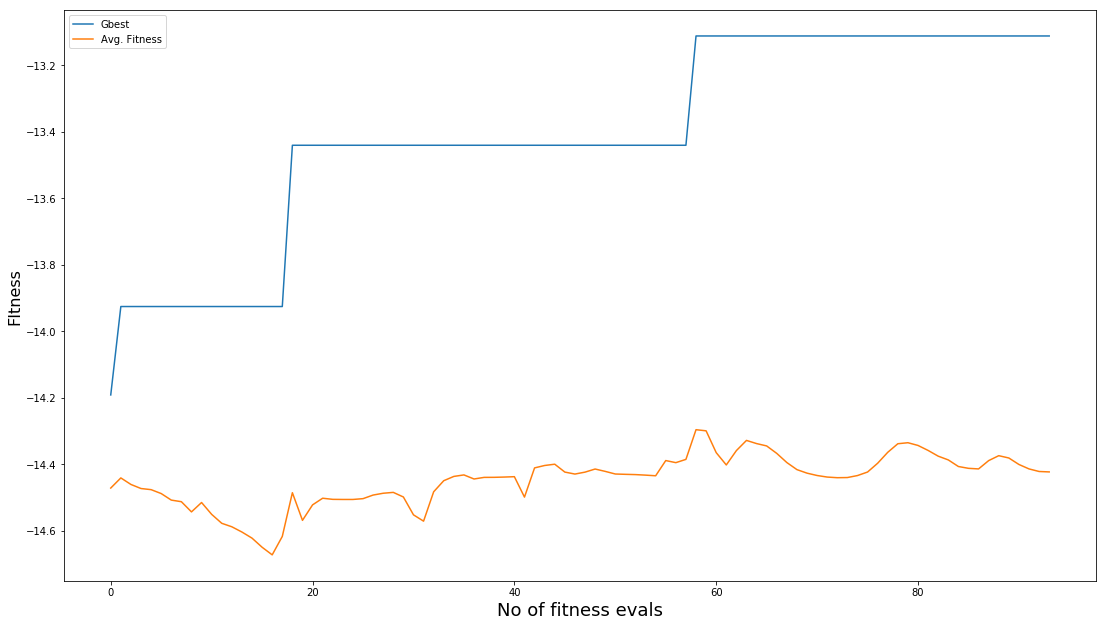

In [25]:
import matplotlib.pyplot as plt

##plt.gca().set_color_cycle(['blue','green'])
plt.gcf().set_size_inches(18.5, 10.5, forward=True)
plt.xlabel('No of fitness evals', fontsize=18)
plt.ylabel('FItness', fontsize=16)

xaxis = [i for i in range(len(gbest_X))]

plt.plot(xaxis, gbest_X )
plt.plot(xaxis, avg_fit_X)

plt.legend(['Gbest','Avg. Fitness'], loc='upper left')
plt.show()

In [ ]:
#del plt

plt.gcf().set_size_inches(18.5, 10.5, forward=True)
plt.xlabel('No Epochs', fontsize=18)
plt.ylabel('Avg. Distance', fontsize=16)
xaxis_avgdist = [i for i in range(len(avg_dist))]
plt.plot(xaxis_avgdist, avg_dist)
plt.legend(['Avg. Dist'], loc='upper left')

plt.show()


In [ ]:
plt.gcf().set_size_inches(19, 11, forward=True)
plt.xlabel('No Epochs', fontsize=18)
plt.ylabel('Test Data Acc', fontsize=16)
xaxis_avgdist = [i for i in range(len(test_data_acc))]
plt.plot(xaxis_avgdist, test_data_acc)
plt.legend(['Test Data Acc'], loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(np.argmax(op_label_test,axis=1), np.argmax(model.predict(test_digits),axis=1))
print(cfm)
print(100*(sum([cfm[i,i] for i in range(cfm.shape[0])])/np.sum(cfm)))